![Demo architecture](img/QPSK_system_block_diagrams_Tx_only.svg)

## Initialisation

Let's include pynq libraries and our own drivers

In [8]:
import xrfdc
import ipywidgets as ipw
from PynqQPSK import QpskOverlay, SdrPlots, DmaTimer, DictWidget

Set up LMX clock synthesizer to 204.8 MHz

Now we're ready to load our bitstream to the PL

In [2]:
ol = QpskOverlay.QpskOverlay("/home/xilinx/rfsoc_qpsk_demo/PynqQPSK/bitstream/base.bit")

### Configuring the RF Data Converters

We are going to use one of the DAC blocks to transmit our signal.
We'll need to generate a clock using one of the on-board synthesizers, tell the data converters about it, and set an NCO frequency --- controlling our signal's carrier frequency. 

![Diagram of on-board synth, DAC block with PLL, and NCO](img/RF_DAC.svg)

Make our RF data converter object

Set DAC's clock source and NCO/mixer frequency

In [28]:
ol.dac_tile.ShutDown()
dac_mixer = {"Freq": 84,
             "CoarseMixFreq": xrfdc.XRF_DC_COARSE_MIX_SAMPLE_FREQ_BY_TWO,
             "CoarseMixMode": xrfdc.XRF_DC_COARSE_MIX_MODE_C2C_C2R,
             "FineMixerMode": xrfdc.XRF_DC_FINE_MIXER_MOD_COMPLX_TO_REAL}
ol.dac_block.MixerSettings = dac_mixer
ol.dac_tile.StartUp()

See `xrfdc.py` for implementation, showing how easily we can wrap existing C drivers as object oriented python drivers!

### Initialise our QPSK TX Design

Finally, we make an instance of a driver for the QPSK transmit logic. This controls the signal processing performed on the signal, as well as tapping off the data path, allowing us to interactively plot the intermediate signals.

See `qpsk_tx.py` for the implementation of the driver, exposing registers as object properties using some data-driven generation

## Visualising internal signals

Now that the transmitter is configured and constantly running in the background, we can capture intermediate signals and visualise them interactively.

Our raw, binary data is carried by two parts ("I" and "Q") in a complex signal.  These each have a value of 1 or -1, conveying 1 bit of information.

Let's make a time domain plot of this signal --- straight after our `symbol generation` block.

### Raw QPSK symbols

Here we generate a time domain plot that updates in real-time. We make use of Pynq's DMA drivers, and a python Timer for scheduled transfers.

In [11]:
cplot = SdrPlots.IQTimePlot(ol.qpsk_tx.getManySymbols(N=10), 500,
                            resampling_fun=SdrPlots.resample_pick)

dg = DmaTimer.DmaTimer(cplot.add_data, ol.qpsk_tx.getSymbols, 0.05)
ipw.VBox([cplot.get_widget(), ipw.HBox(dg.getControls())])

    'data': [{'name': ' I',
              'type': 'scatter',
              'uid'…

We can stream in more live data using the play/stop buttons.

Alright, cool! But changing this signal instantaneously from -1 to 1 means there's a near infinite bandwidth (i.e. has components in all frequencies!). To help suppress this for successful transmission, we perform some `pulse shaping`.

### Pulse shaping

Next we make the same plot, but with data from after our pulse shaping unit. First we'll see this in the time domain, then we will look at the same signal in the frequency domain.

In [13]:
iq_plot = SdrPlots.IQTimePlot(ol.qpsk_tx.getManyShapedTime(N=10), 4000,w=800)
iq_dg = DmaTimer.DmaTimer(iq_plot.add_data, ol.qpsk_tx.getShapedTime, 0.05)

fa_plot = SdrPlots.HWFreqPlot(ol.qpsk_tx.getShapedFFT(), 4000, avg_n=4,w=800)
fa_dg = DmaTimer.DmaTimer(fa_plot.add_frame, ol.qpsk_tx.getShapedFFT, 0.3)

tab1 = ipw.Tab([ipw.VBox([iq_plot.get_widget(), ipw.HBox(iq_dg.getControls())]),
                ipw.VBox([fa_plot.get_widget(), ipw.HBox(fa_dg.getControls())])
               ])
tab1.set_title(0, 'Time domain')
tab1.set_title(1, 'Frequency domain')
tab1

    'data': [{'name': ' I',
              'type': 'scatter',
     …

## Dynamic Control

We can also use widgets to control our PL settings visually. For example, our mixer's NCO frequency and the gain of the signal.

First, let's write some JSON that describes our settings and their valid ranges.

In [14]:
import json

schema_json = """
{
  "title": "TX Settings",
  "type": "object",
  "properties": {
    "Freq": {
      "description": "NCO Frequency (MHz)",
      "type": "number",
      "minimum": 0.0,
      "maximum": 100.0,
      "default": 84.0
    },
    "Gain": {
      "description": "Relative Gain",
      "type": "number",
      "minimum": 0.0,
      "maximum": 1.0,
      "default": 1
    }
  }
}
"""


Now, let's define a function that will take a dictionary of these settings and apply them to our system. We must ensure that only one instance of this is run at a given time (using Python's `Lock()`) because our driver isn't thread safe (yet).

In [29]:
from threading import Thread, Lock

tx_mutex = Lock()

def update_tx_settings(config):
    # Acquire lock for mutual exclusion on RF driver
    if tx_mutex.acquire(blocking=False):
        # Now work in a try block so we will always release the lock, even if our code fails
        try:
            if 'Gain' in config.keys():
                ol.qpsk_tx.axi_qpsk_tx.output_gain = int(config['Gain']*(2**32-1))
            if 'Freq' in config.keys():
                ol.dac_tile.ShutDown()
                mixer_cfg = ol.dac_block.MixerSettings
                mixer_cfg['Freq'] = config['Freq']
                ol.dac_block.MixerSettings = mixer_cfg
                ol.dac_tile.StartUp()
        except:
            pass
        # Remember to release the lock
        tx_mutex.release()

Finally we can make our widget and play with the values.

See the effect of changing the gain in the FFT and time domain signal. The effect of the NCO mixer is a bit more subtle --- keep an eye out for a look of suppressed horror on Kenny's face as his receiver gets out of sync!

In [16]:
cfg = DictWidget.DictWidget(json.loads(schema_json))
gui = cfg.interact(callback=update_tx_settings)
display(gui)

# QPSK Receiver

Now that the transmitter is configured, we start to play with the receiver side.

![Demo architecture](img/QPSK_system_block_diagrams_Rx_only.svg)

## Config

First, we configure the RF ADC block. The ADC tile's PLL is configured, and make sure to match the block's mixer frequency with the transmitting side! For us that's 84 MHz unless you've been playing with the sliders above...

In [30]:
ol.adc_tile.ShutDown()

adc_mixer = {"Freq": 84.000,
             "CoarseMixFreq": xrfdc.XRF_DC_COARSE_MIX_SAMPLE_FREQ_BY_TWO,
             "CoarseMixMode": 2,
             "FineMixerMode": 3,
             "EventSource": 2}
ol.adc_block.MixerSettings = adc_mixer

ol.adc_tile.StartUp()

## Decimated signal

Now we can start inspecting some of the received signals.
Below, we can grab data from multiple parts of our RX signal path and plot them in the time domain, frequency domain, or as a constellation.

Feel free to change the first line to swap between inspecting the raw signal after decimation, after coarse synchronisation, or after the RRC.

In [32]:
taps = {
    'Decimated': 
      {'get': ol.qpsk_rx.getDecimated,    'getMany': ol.qpsk_rx.getManyDecimated,    'fs':1024},
    'CoarseSynced': 
      {'get': ol.qpsk_rx.getCoarseSynced, 'getMany': ol.qpsk_rx.getManyCoarseSynced, 'fs':4096},
    'RRCed': 
      {'get': ol.qpsk_rx.getRRCed,        'getMany': ol.qpsk_rx.getManyRRCed,        'fs':16384}
}

tap = 'Decimated'
#     ^^^^^^^^^^^
#    Pick between Decimated, CoarseSynced, RRCed, or Data

f=taps[tap]['get']
d=taps[tap]['getMany']()
fs=taps[tap]['fs']

f_plot = SdrPlots.IQFreqPlot(f(), fs)
f_dg = DmaTimer.DmaTimer(f_plot.add_frame, f, 0.3)

iq_plot = SdrPlots.IQTimePlot(d, fs, w=800)
iq_dg = DmaTimer.DmaTimer(iq_plot.add_data, f, 0.05)

c_plot = SdrPlots.IQConstellationPlot(d, plotrange=(0, len(d)-1), fade=True)
c_dg = DmaTimer.DmaTimer(c_plot.add_data, f, 0.05)

tab1 = ipw.Tab([ipw.VBox([iq_plot.get_widget(), ipw.HBox(iq_dg.getControls())]),
                ipw.VBox([f_plot.get_widget(), ipw.HBox(f_dg.getControls())]),
                ipw.VBox([c_plot.get_widget(), ipw.HBox(c_dg.getControls())]),])
tab1.set_title(0, 'Time domain')
tab1.set_title(1, 'Frequency domain')
tab1.set_title(2, 'Constellation')
tab1

    'data': [{'name': ' I',
              'type': 'scatter',
     …

# Output data

Finally we can plot a constellation of the final, synchronised signal, showing the 4 constellations expected of QPSK. The transparency of each sample represents its "age", as there in no explicit time axis for constellation plots. On our test system, ~20 frames per second is achievable.

In [26]:
# Pick between getDecimated, getCoarseSynced, getRRCed, or getData
d=ol.qpsk_rx.getManyData()
fs=500

iq_plot = SdrPlots.IQTimePlot(d, fs, w=800)
iq_dg = DmaTimer.DmaTimer(iq_plot.add_data, ol.qpsk_rx.getData, 0.05)

c_plot = SdrPlots.IQConstellationPlot(d, plotrange=(0, len(d)-1), fade=True)
c_dg = DmaTimer.DmaTimer(c_plot.add_data, ol.qpsk_rx.getData, 0.05)

tab1 = ipw.Tab([ipw.VBox([c_plot.get_widget(), ipw.HBox(c_dg.getControls())]),
                ipw.VBox([iq_plot.get_widget(), ipw.HBox(iq_dg.getControls())])])
tab1.set_title(0, 'Constellation')
tab1.set_title(1, 'Time domain')
tab1

    'data': [{'marker': {'opacity': array([ 0.        ,  0.0062893…

## Scratch pad

Everything below this point is not part of the main demo --- just an environment for testing and having a play around.

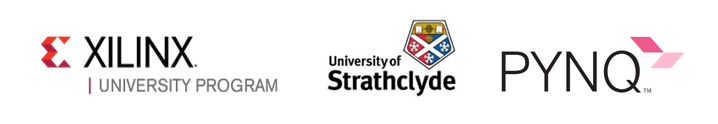

In [27]:
from IPython.display import Image
Image("img/combined.png")

## Profiling of plotting code

Note: need to pip install line_profiler before this will work.

Very useful approach for spotting any server-side bottleneck in our live plots.
Cell below is marked as "Raw", so we can "Run all cells" without breaking anything.

...or alternatively, just use a simple timer with no line-by-line feedback